<a href="https://colab.research.google.com/github/RosemaryYool/Notes-for-AI-in-Science-and-Medicine/blob/main/Hahn_2023_Classify1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from imageio import *
import torch
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision.models import *
from torchvision.datasets import MNIST,KMNIST,FashionMNIST
from skimage.util import montage
from scipy import stats

In [2]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [3]:
b = 1000

def get_batch(mode):
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y


## MNIST
    

### Load Data

In [48]:
# #MNIST
#train_set = MNIST('./data', train=True, download=True)
#test_set  = MNIST('./data', train=False, download=True)

#KMNIST
train_set = KMNIST('./data', train=True, download=True)
test_set =  KMNIST('./data', train=False, download=True)

# Fashion MNIST
#train_set = FashionMNIST('./data', train=True, download=True)
#test_set =  FashionMNIST('./data', train=False, download=True)

100%|██████████| 18165135/18165135 [00:16<00:00, 1114486.02it/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 204239.64it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 906470.13it/s] 


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 16869470.92it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [49]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()

X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255

In [50]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [51]:
X = GPU_data(X)
Y = GPU_data(Y)
X_test = GPU_data(X_test)
Y_test = GPU_data(Y_test)

In [52]:
X = X.reshape(X.shape[0],784)
X_test = X_test.reshape(X_test.shape[0],784)

In [53]:
X.shape

torch.Size([60000, 784])


### Classifier


In [54]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [55]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [56]:
def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  

In [57]:
def acc(out,y):
    return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [58]:
def get_batch(mode):
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [59]:
x,y = get_batch('train')

In [60]:
x.shape

torch.Size([1000, 784])

In [61]:
def model(x,w):

    return x@w[0]

In [62]:
def gradient_step(w):

    w[0].data = w[0].data - L*w[0].grad.data
    
    w[0].grad.data.zero_()

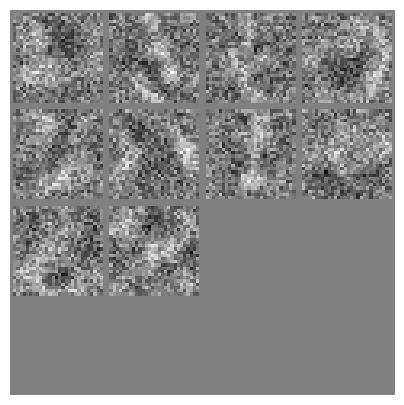

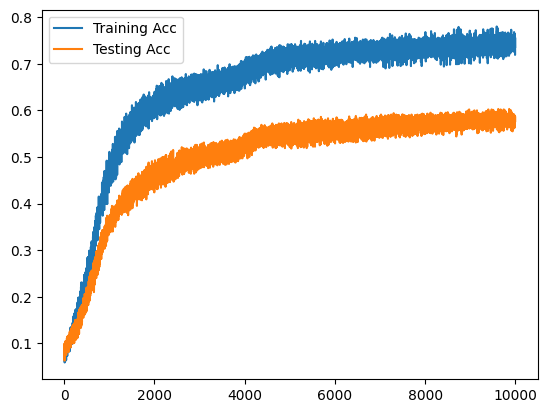

In [63]:
L = 0.01
b = 1000
steps = 10000

train_acc = np.zeros(steps,)
test_acc = np.zeros(steps,)

w = [GPU(randn_trunc((784,10)))]

for i in range(steps):

    x,y = get_batch('train')

    out = model(x,w)

    loss = cross_entropy(softmax(out),y)

    loss.backward()

    gradient_step(w)

    
    xt,yt = get_batch('test')
    test_acc[i] = acc(model(xt,w),yt) 
    train_acc[i] = acc(model(x,w),y)
    


montage_plot((w[0].T).reshape(10,28,28).cpu().detach().numpy())
plt.plot(train_acc[0:i])
plt.plot(test_acc[0:i])
plt.legend(['Training Acc', 'Testing Acc'])
plt.show()

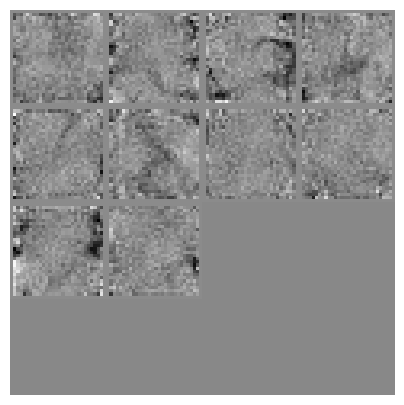

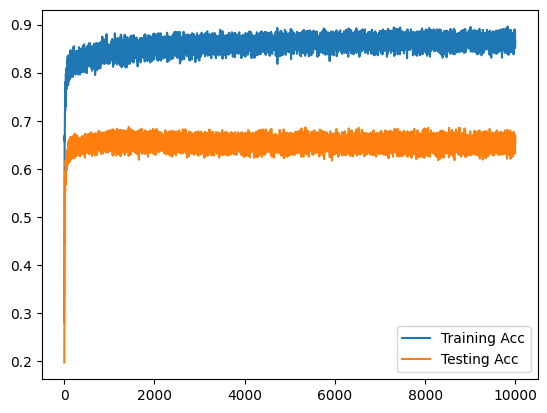

In [64]:
L = 0.01
b = 1000
steps = 10000

train_acc = np.zeros(steps,)
test_acc = np.zeros(steps,)

w = [GPU(randn_trunc((784,10)))]

optimizer = torch.optim.Adam(w, lr=L)  

for i in range(steps):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    xt,yt = get_batch('test')
    test_acc[i] = acc(model(xt,w),yt) 
    train_acc[i] = acc(model(x,w),y)
    


montage_plot((w[0].T).reshape(10,28,28).cpu().detach().numpy())
plt.plot(train_acc[0:i])
plt.plot(test_acc[0:i])
plt.legend(['Training Acc', 'Testing Acc'])
plt.show()